# Heart Disease Prediction - EDA and Modeling

**MLOps (S1-25_AIMLCZG523) ASSIGNMENT - I : MLOps Experimental Learning Assignment**

**Objective**:  End-to-End ML Model Development, CI/CD, and Production Deployment Experimental Learning

**Dataset**: Title - Heart Disease UCI Dataset

### Group ID: 115
<hr>

### Group Members Name with Student ID:
<hr>

1. 2024AA05721      MAJJIGI JAMBANNA	
2. 2024AA05405      NIRANJAN KUMAR SHARMA           
3. 2024AA05402      SRIDEVI THAKKU RAMANAN
4. 2024AA05593      TRIPTI
5. 2024AA05139      HARSHAL KISHORE PHADAS

<hr>



In [ ]:
#!pip install mlflow


### 1. Import Required Libraries and Configuration



In [32]:

# --------------------------------------------------------------
# Heart Disease Prediction – EDA and Modeling
# MLOps Assignment – End‑to‑end ML pipeline with tracking
# --------------------------------------------------------------    

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn
import os

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

## 2. Data Acquisition and Cleaning

In [33]:

# --------------------------------------------------------------
# DATA ACQUISITION & CLEANING
# --------------------------------------------------------------

# Load data
df = pd.read_csv('../data/heart_disease.csv')

# 1. Preview data
print("\n--- Head ---")
print(df.head())


# 2. Shape
print("\n--- Shape ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")


# 3. Data types
print("\n--- Data Types ---")
print(df.dtypes)



--- Head ---
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

--- Shape ---
Rows: 303, Columns: 14

--- Data Types ---
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int64
dtype

In [34]:
# 4. Missing values check
print("Missing values:\n", df.isnull().sum())

# The 'ca' and 'thal' columns had '?' in original UCI dataset, 
# handled during download by setting na_values='?'
df = df.fillna(df.median())
print("\nMissing values after imputation:\n", df.isnull().sum())


# 5. Duplicate rows check
print("\n--- Duplicate Rows ---")
print(df.duplicated().sum())


# 6. Basic statistics
print("\n--- Summary Statistics ---")
print(df.describe(include='all'))



Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

--- Duplicate Rows ---
0

--- Summary Statistics ---
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.

## 3. Exploratory Data Analysis (EDA)

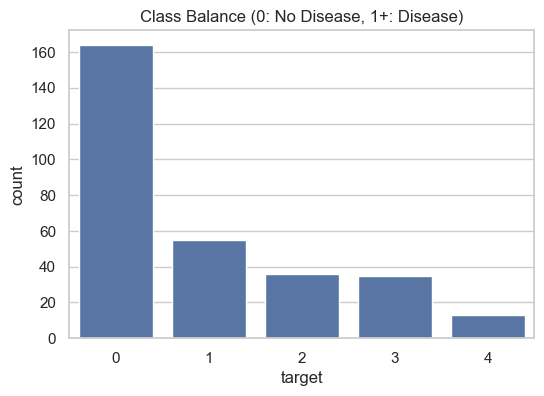

In [35]:

# --------------------------------------------------------------
# EXPLORATORY DATA ANALYSIS (EDA)
# --------------------------------------------------------------

# Class Balance
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Class Balance (0: No Disease, 1+: Disease)')
plt.show()

# Convert target to binary: 0 vs 1+ (UCI heart disease target > 0 means disease)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

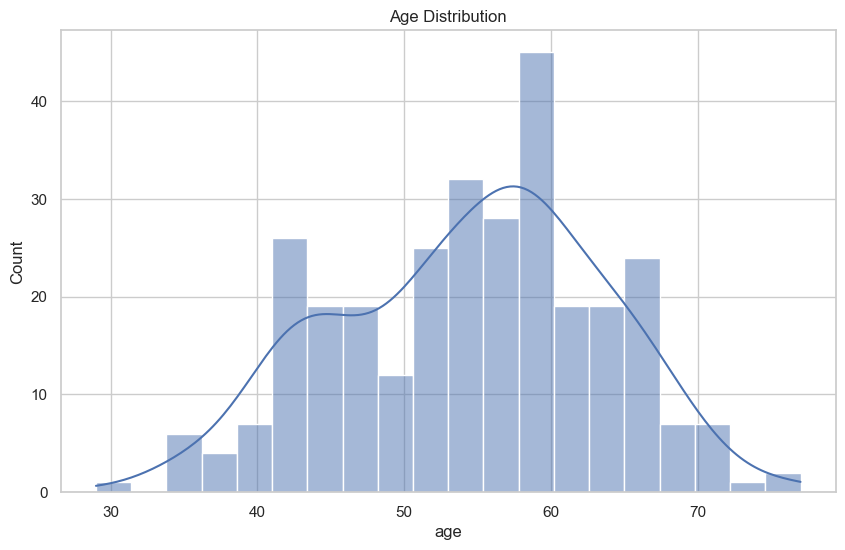

In [36]:
# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Age Distribution')
plt.show()

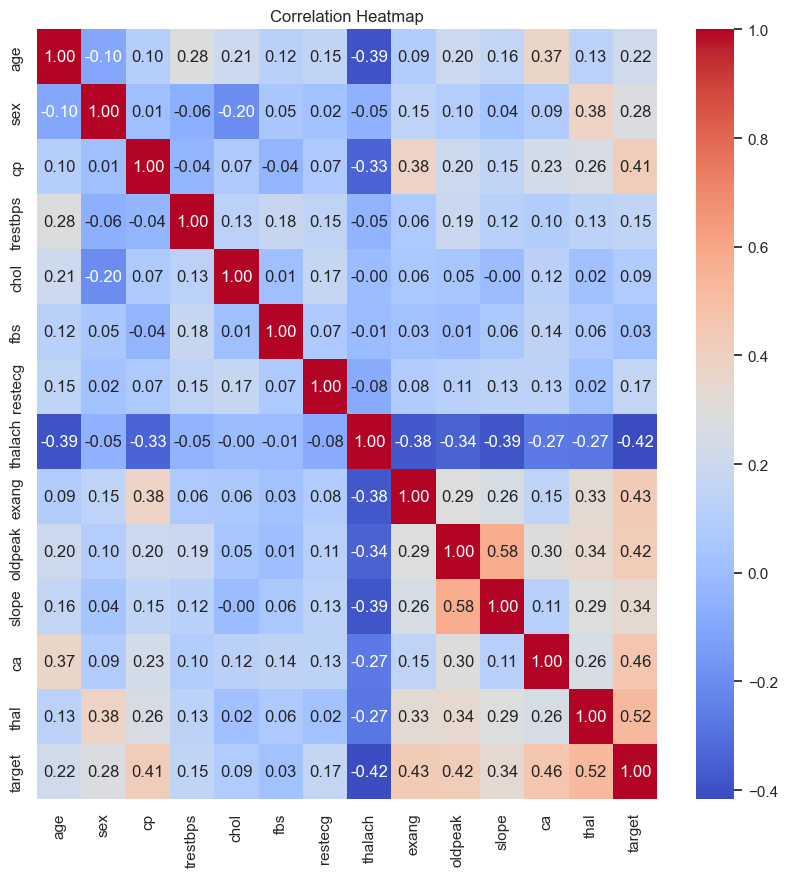

In [37]:
# Correlation Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## 4. Feature Engineering & Preprocessing

In [38]:

# --------------------------------------------------------------
# FEATURE ENGINEERING & PREPROCESSING
# --------------------------------------------------------------

X = df.drop('target', axis=1)
y = df['target']

# Numerical and Categorical columns
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Model Development & Experiment Tracking

In [39]:

# --------------------------------------------------------------
# MODEL TRAINING + MLFLOW EXPERIMENT TRACKING
# --------------------------------------------------------------

def train_and_log_model(model_name, model, X_train, y_train, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
       
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_prob)
        }
        
        mlflow.log_params(model.get_params())
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"--- {model_name} Results ---")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")
        print(classification_report(y_test, y_pred))
        
        return pipeline

In [40]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_pipeline = train_and_log_model("Logistic_Regression", lr_model, X_train, y_train, X_test, y_test)

2025/12/24 21:09:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--- Logistic_Regression Results ---
accuracy: 0.8361
precision: 0.8438
recall: 0.8438
f1_score: 0.8438
roc_auc: 0.9159
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



In [41]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pipeline = train_and_log_model("Random_Forest", rf_model, X_train, y_train, X_test, y_test)

2025/12/24 21:10:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--- Random_Forest Results ---
accuracy: 0.8525
precision: 0.8966
recall: 0.8125
f1_score: 0.8525
roc_auc: 0.9402
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.90      0.81      0.85        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



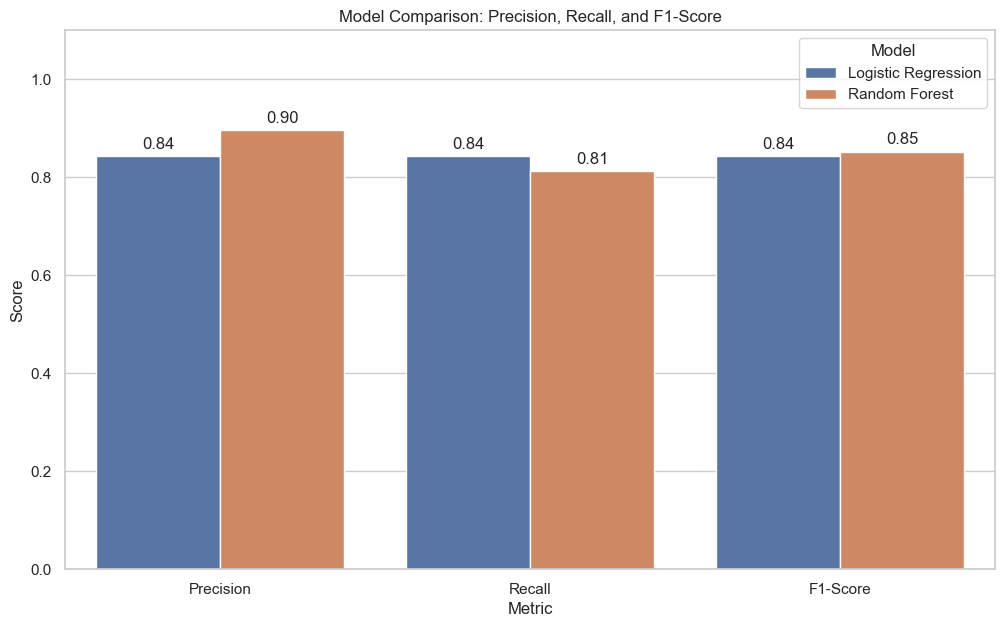

In [42]:

# --------------------------------------------------------------
# MODEL PERFORMANCE COMPARISON
# --------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

def get_metrics(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    return {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

# Assuming lr_pipeline and rf_pipeline are already trained
lr_metrics = get_metrics(lr_pipeline, X_test, y_test)
rf_metrics = get_metrics(rf_pipeline, X_test, y_test)

results_df = pd.DataFrame([lr_metrics, rf_metrics], index=['Logistic Regression', 'Random Forest'])
results_df = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(data=results_df, x='Metric', y='Score', hue='index')
plt.title('Model Comparison: Precision, Recall, and F1-Score')
plt.ylim(0, 1.1)
plt.legend(title='Model', loc='upper right')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', padding=3)
plt.show()

## 6.  Model Packaging & Reproducibility

In [43]:

# --------------------------------------------------------------
# SAVE BEST MODEL (Random Forest)
# --------------------------------------------------------------

# Save the best model (Random Forest for demonstration)
import pickle
os.makedirs('../models', exist_ok=True)
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(rf_pipeline, f)
print("Model saved to models/model.pkl")

Model saved to models/model.pkl
